In [1]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix#, silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process.kernels import RBF

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Utiles

In [2]:
def cargar(fold="data/sin adulterar", one_row=False, clase=0):
    """ Devuelve los datos de la bolsa indicada en el argumento 'fold'.
        one_row: Determina si los datos de cada file deben ser devueltos
        como una sola fila, o no.
        clase: nro de clase que se asignará a los datos de la bolsa.
    """
    aux = pd.DataFrame()
    files = os.listdir(fold+"/")
    for f in files:
#         print("{}/{}".format(fold,f))
        dfu = pd.read_csv(fold+"/"+f, index_col=[0], names=["amp"])
        if one_row:
            dfu = dfu.T
        
        dfu["clase"] = clase
        aux = pd.concat([aux, dfu], ignore_index=True)
    return aux


def load_data(dif=False, one_row=True):
    """ Devuelve todos los datos en un solo dataframe.
        one_row: Determina si los datos de cada file deben ser devueltos
        como una sola fila, o no.
        dif: Determina si cada bolsa se cargará con un nro de clase
        diferente (True), o solo se diferenciará la clase 'sin adulterar'(False).
    """
    sin_adulterar = cargar(one_row=one_row)
    adulterados = pd.DataFrame()
    
    folds = os.listdir("data/")
    clases = pd.DataFrame(index=folds)
    folds.remove("sin adulterar")
    clases["sin adulterar"] = 0
    for i, f in enumerate(folds):
        if dif:
            ad = cargar("data/"+f, one_row=one_row, clase=i+1)
            clases[f] = i+1
        else:
            ad = cargar("data/"+f, one_row=one_row, clase=1)
            clases[f] = 1
        adulterados = pd.concat([adulterados,ad], ignore_index=True)
    data_comp = pd.concat([sin_adulterar, adulterados], ignore_index=True)
    return clases, data_comp

def load_par(folds, one_row=True):
    """ Carga los 2 files indicados en 'folds', sustrayendoles a sus valores
        el promedio de los datos 'sin adulterar' y los devuelve en un dataframe.
        one_row: Determina si los datos de cada file deben ser devueltos
        como una sola fila, o no.
    """
    sin = cargar(one_row=one_row)
    sin = pd.DataFrame(sin.mean(axis=0)).T

    comp = pd.DataFrame()
    resta = pd.DataFrame()
    d1 = cargar("data/"+folds[0], one_row=one_row, clase=0)
    d2 = cargar("data/"+folds[1], one_row=one_row, clase=1)
    comp = pd.concat([d1, d2], ignore_index=True)
    
    for index, row in comp.iloc[:,:-1].iterrows():
        aux = sin.iloc[:,:-1] - row
        resta = pd.concat([resta, aux], ignore_index=True)
    resta["clase"] = comp["clase"]
    return resta
    

def load_data_dif(clase="sin adulterar", dif=False, one_row=True):
    """ Devuelve todos los datos en un solo dataframe.
        one_row: Determina si los datos de cada file deben ser devueltos
        como una sola fila, o no.
        dif: Determina si cada bolsa se cargará con un nro de clase diferente
        (True), o solo se diferenciará la bolsa indicada en 'clase'(False).
    """
    clase_0 = cargar("data/"+clase, one_row=one_row)
    adulterados = pd.DataFrame()
    
    folds = os.listdir("data/")
    clases = pd.DataFrame(index=folds)
    folds.remove(clase)
    clases[clase] = 0
    for i, f in enumerate(folds):
        if dif:
            ad = cargar("data/"+f, one_row=one_row, clase=i+1)
            clases[f] = i+1
        else:
            ad = cargar("data/"+f, one_row=one_row, clase=1)
            clases[f] = 1
        adulterados = pd.concat([adulterados,ad], ignore_index=True)
    data_comp = pd.concat([clase_0, adulterados], ignore_index=True)
    return clases, data_comp


def plot_confusion_matrix(cm, classes, title='Confusion matrix', norm=True):
    """
    Esta función imprime una matriz de confución. El parámetro 'norm' determina si los valores deben
    mostrarse como recuento total de las ocurrencias, o como medida porcentual donde 1 es el total
    """
    if norm:
        cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
    thresh = cm.max() / 2.
    
    cmap = plt.cm.Blues
    fig = plt.figure(title, figsize=(7, 7))
    plt.clf()
    plt.title(title)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    res = ax.imshow(np.array(cm), cmap=plt.cm.Blues, 
                    interpolation='nearest')
    fig.colorbar(res)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        aux = cm[i, j]
        if aux == 0:
            continue
        plt.text(j, i, str(aux),
                 horizontalalignment="center",
                 color="r")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    
    
def plot_matrix_on_ax(ax, cm, classes, title='Confusion matrix', norm=True):
    """
    Esta función imprime una matriz de confución. El parámetro 'norm' determina si los valores deben
    mostrarse como recuento total de las ocurrencias, o como medida porcentual donde 1 es el total
    """
    if norm:
        cm = np.around(cm / cm.sum(axis=1)[:, np.newaxis], 2)
    thresh = cm.max() / 2.
    
    cmap = plt.cm.Blues
    ax.set_aspect(1)
    res = ax.imshow(np.array(cm), cmap=plt.cm.Blues, 
                    interpolation='nearest', vmin=0, vmax=1)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        aux = cm[i, j]
        if aux == 0:
            continue
        ax.text(j, i, str(aux), size=15,
                 horizontalalignment="center",
                 color="r")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)#, rotation=45)
    ax.set_yticks(tick_marks, classes)
    
    ax.set_title(title)
    ax.set_xlabel('True label')
    ax.set_ylabel('Predicted label')
    return res

def plot_data(data, clases, tit="graph"):    
    fig = plt.figure(tit)
    ax = plt.subplot(111)
    cmap = plt.cm.jet
    cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
    colors = cmap.from_list('Custom cmap', cmaplist, cmap.N) # create the new map
    result = ax.scatter(data[:, 0], data[:, 1], c=clases, cmap=colors)
    fig.colorbar(result)
    plt.show()

    
def plot_data_train_test(data, clases, train, test, names=["sin adulterar", "adulterado"]):
    tit="graph"
    fig = plt.figure(tit, figsize=(12, 4))
#     ax = plt.subplot(1, 3, 1)
    ax1 = plt.subplot(1, 3, 1)
#     cmap = plt.cm.jet
    cmap = plt.cm.winter
    cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the .jet map
    colors = cmap.from_list('Custom cmap', cmaplist, cmap.N) # create the new map
    if len(np.unique(clases)) == len(names):
        l = [names[x] for x in np.unique(clases)]
        plt.scatter(data[:, 0], data[:, 1], c=clases, cmap=colors)
        plt.legend(l, loc=4)
    else:
        plt.scatter(data[:, 0], data[:, 1], c=clases, cmap=colors)

    plt.title("Data")
    
    plt.subplot(1, 3, 2, sharey=ax1, sharex=ax1)
    plt.scatter(train["x"][:, 0], train["x"][:, 1], c=train["y"], cmap=colors)
    plt.title("Train")
    
    plt.subplot(1, 3, 3, sharey=ax1, sharex=ax1)
    plt.scatter(test["x"][:, 0], test["x"][:, 1], c=test["y"], cmap=colors)
    plt.title("Test")
#     fig.colorbar(ax1)
    plt.show()


    
def clasificar(train_x, train_y, test_x, test_y, clases, kernel="linear", grado=2):
    a_dtree = tree.DecisionTreeClassifier(criterion="entropy", max_features="log2", random_state=15, max_depth=10)
    a_etree = ExtraTreesClassifier(n_jobs=4, random_state=15)
    a_mlp = MLPClassifier(alpha=1, random_state=15)
    # Gaussian con 'multi_class=one_vs_one' clasifica sin error como los otros
    a_gpc = GaussianProcessClassifier(n_jobs=4, multi_class="one_vs_rest", random_state=15)
    a_knn = KNeighborsClassifier(n_jobs=4)
    a_svc = SVC(C=1, kernel=kernel)

    cls = [("DecisionTreeClassifier", a_dtree),
           ("ExtraTreesClassifier", a_etree),
           ("MLPClassifier", a_mlp),
           ("GaussianProcessClassifier", a_gpc),
           ("KNeighborsClassifier", a_knn),
           ("SVC '{}'(degree {})".format(kernel, grado), a_svc)]

    coord = [(x,y) for x, y in itertools.product(range(2), range(3))]
    fig, axarr = plt.subplots(2, 3, figsize=(12, 7))

    plt.xticks(rotation=70)
    
    for (x, y), (n, c) in zip(coord, cls):
        c.fit(train_x, train_y)

        a_predict = c.predict(test_x)
        a_mat = confusion_matrix(test_y, a_predict)
#         cm = plot_confusion_matrix(a_mat, clases, title=n)
        im = plot_matrix_on_ax(axarr[x, y], a_mat, clases, title=n)
        plt.tight_layout()
        
    bar = fig.add_axes([1.05, 0, 0.03, 1])
    fig.colorbar(im, cax=bar)
    plt.show()
    return

pipe = Pipeline([("sca", StandardScaler()),
                 ("pca", PCA(n_components=2, random_state=15)), # 2 components = 97% variance
                ])

## Loading, Proccessing and Spliting Data

In [3]:
sin = cargar(one_row=True)
clases, datos = load_data_dif(dif=False)
datos.shape

(446, 1558)

In [4]:
clases[:1]

,sin adulterar,"sudan 2 - 2,5%",sudan 1 - 5%,sudan 2 - 1%,"sudan 1 - 2,5%",sudan 2 - 5%,para red - 5%,sudan 3 - 5%,para red - 1%,sudan 1 - 1%,"para red - 2,5%"
"sudan 2 - 2,5%",0,1,1,1,1,1,1,1,1,1,1


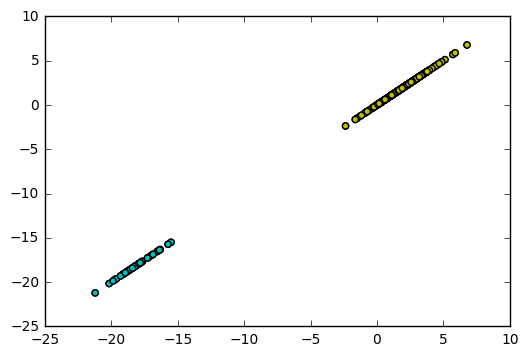

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sca = StandardScaler()
lda = LinearDiscriminantAnalysis(n_components=2)

scaled_data = sca.fit_transform(datos.iloc[:,:-1])
x_train, x_test, y_train, y_test = train_test_split(scaled_data, datos["clase"])

xx_train = lda.fit_transform(x_train, y_train)
xx_test = lda.transform(x_test)

dt = pd.concat([pd.DataFrame(xx_train), pd.DataFrame(xx_test)], ignore_index=True)
rta = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)], ignore_index=True)

# tr, ts = {"x":xx_train, "y":y_train}, {"x":xx_test, "y":y_test}
# plot_data_train_test(dt.values, rta, tr, ts)

col = ["c", "y"]
colores = [col[x] for x in rta["clase"]]
plt.figure()

for c in np.unique(rta["clase"]):
    plt.scatter(dt[:], dt[:], c=colores)
plt.show()

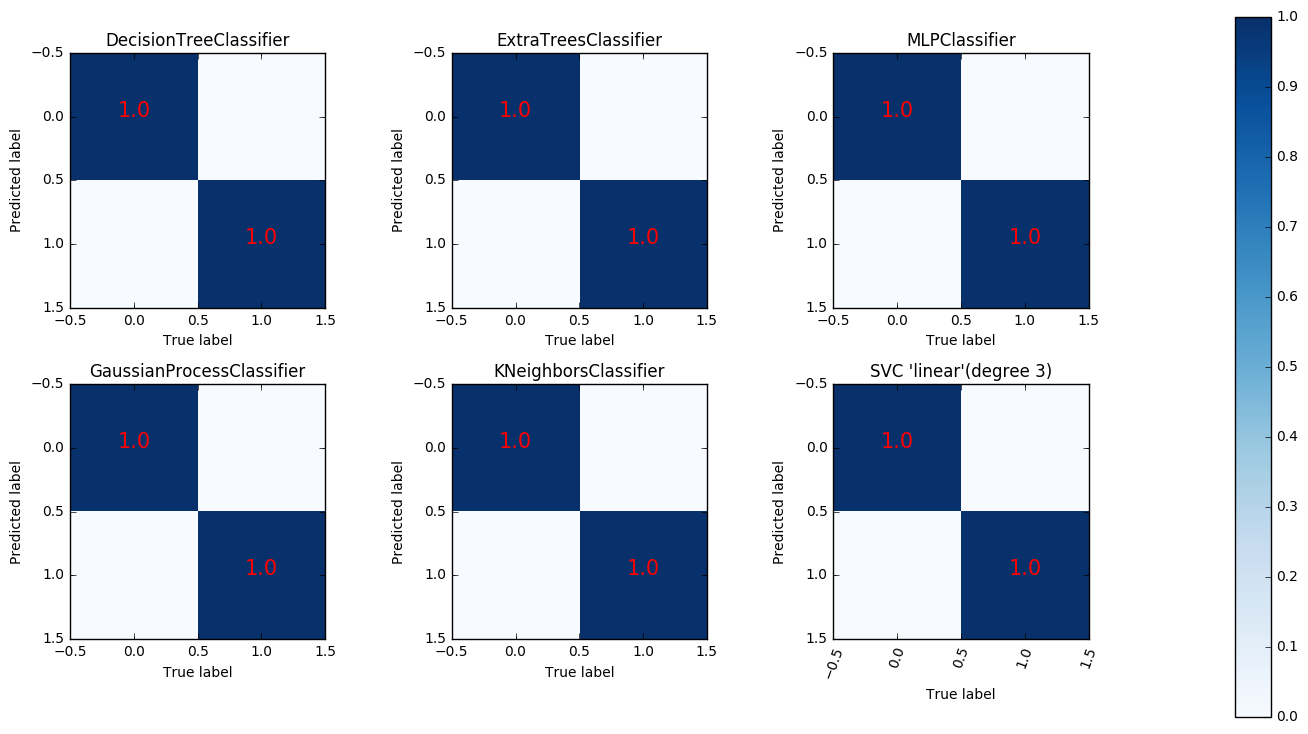

In [6]:
clasificar(xx_train, y_train, xx_test, y_test, ["sin adulterar", "adulterado"], "linear", 3)

In [7]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([  9, 103]))

## Con 3 y 4 clases a la vez

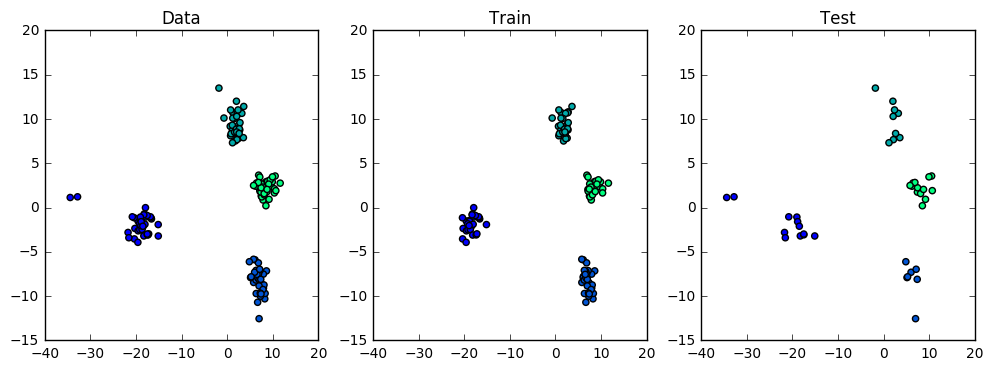

In [8]:
sin = cargar(one_row=True)
sudan1 = cargar("data/sudan 1 - 1%", one_row=True, clase=1)
para = cargar("data/para red - 1%", one_row=True, clase=2)
sudan2 = cargar("data/sudan 2 - 1%", one_row=True, clase=3)


# data = pd.concat([sin, sudan1, para], ignore_index=True)
data = pd.concat([sin, sudan1, para, sudan2], ignore_index=True)


c_train_x, c_test_x, c_train_y, c_test_y = train_test_split(data.iloc[:,:-1], data["clase"])

# lda = LinearDiscriminantAnalysis(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=3)

c_train_xx = lda.fit(c_train_x, c_train_y).transform(c_train_x)
c_test_xx = lda.transform(c_test_x)

comp_again = pd.concat([pd.DataFrame(c_train_xx), pd.DataFrame(c_test_xx)], ignore_index=True)
rta_again = pd.concat([pd.DataFrame(c_train_y), pd.DataFrame(c_test_y)], ignore_index=True)

tr, ts = {"x":c_train_xx, "y":c_train_y}, {"x":c_test_xx, "y":c_test_y}
plot_data_train_test(comp_again.values, rta_again, tr, ts)

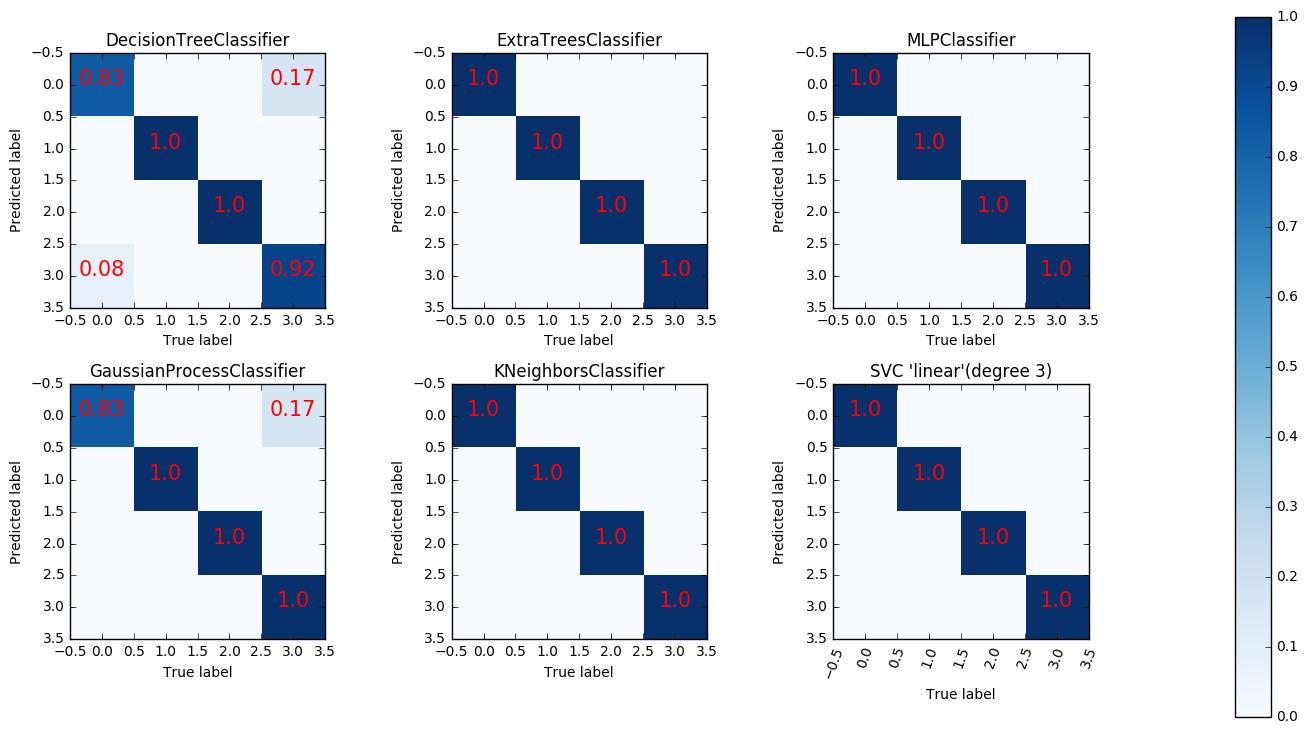

In [9]:
clasificar(c_train_xx, c_train_y, c_test_xx, c_test_y, ["sin adulterar", "sudan 1", "parared", "sudan 2"], "linear", 3)